# Sellers Clusters Analysis with Kmeans and Hierachical Clustering

The Olist dataset available in kaggle (https://www.kaggle.com/olistbr/brazilian-ecommerce) contains more than 100k online orders made from 2016 to 2018. Olist is a Brazilian company that focuses on marketplaces. Basically, it aggregates sellers to announce their products in marketplaces such as Mercado Livre, Via Varejo, Amazon and others. Check their wikipedia page (https://pt.wikipedia.org/wiki/Olist) or their website for more information (https://olist.com/).

A lot of work has already been done in customers clustering for this dataset. By my reckoning, the customers (people who buy online) are just one part of the marketplace users. OK, alright! Perhaps they are the most important part. Nevertheless, you also have the sellers. Do they have common characteristics? Can they be divided in clusters that share the same principles and take similar actions on the market? That is what I decided to find out.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import plotly.graph_objs as go

# Loading and Preparing the dataset

First of all, I loaded the dataset. All the work was done in Google Colab, so I had to use Google Drive for storage. 

Note: The product categories were in Portuguese in the table olist_products_dataset.csv, but a translation was available in the dataset. I just merged it all together in the products DataFrame.  

In [2]:
#from google.colab import drive
#drive.mount('/content/drive/',force_remount=True)
#path = 'drive/MyDrive/Colab Notebooks/UCSesp_ML1/Olist_dataset/'

# replace the product categorie names to english
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
products.rename(columns={'product_name_lenght':'product_name_length',
                         'product_description_lenght':'product_description_length'
                         },inplace=True)#just a typo correction
category_translation = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')
products = pd.merge(products, category_translation,how="left",
                    on="product_category_name")
products.drop(["product_category_name"], axis=1, inplace=True)
products = products.rename(columns={"product_category_name_english":
                                    "product_category_name"})
o_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
o_reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
geoloc = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv")
sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")
o_payments = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")
customers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")

olist = orders.merge(o_items, on='order_id', how='left')
olist = olist.merge(o_payments, on='order_id', how='outer', validate='m:m')
olist = olist.merge(o_reviews, on='order_id', how='outer')
olist = olist.merge(products, on='product_id', how='outer')
olist = olist.merge(customers, on='customer_id', how='outer')
olist = olist.merge(sellers, on='seller_id', how='outer')
olist.drop(['customer_id','order_purchase_timestamp','order_approved_at',
           'order_delivered_carrier_date','payment_sequential','review_id',
           'payment_type','payment_installments','review_id',
           'review_comment_title','review_comment_message','product_weight_g',
            'product_length_cm','product_height_cm','product_width_cm',
            'customer_unique_id','customer_zip_code_prefix',
            'customer_zip_code_prefix','customer_city','seller_zip_code_prefix',
            'seller_city','shipping_limit_date'],axis=1, inplace=True)

olist = olist.dropna()
olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113209 entries, 0 to 119142
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113209 non-null  object 
 1   order_status                   113209 non-null  object 
 2   order_delivered_customer_date  113209 non-null  object 
 3   order_estimated_delivery_date  113209 non-null  object 
 4   order_item_id                  113209 non-null  float64
 5   product_id                     113209 non-null  object 
 6   seller_id                      113209 non-null  object 
 7   price                          113209 non-null  float64
 8   freight_value                  113209 non-null  float64
 9   payment_value                  113209 non-null  float64
 10  review_score                   113209 non-null  float64
 11  review_creation_date           113209 non-null  object 
 12  review_answer_timestamp       

In [3]:
olist.groupby("order_status").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False)

,order_id
order_status,
delivered,94480
canceled,6


Part of the orders were not delivered, so I deleted them.

In [4]:
olist = olist[olist.order_status=='delivered']
olist = olist.drop(columns='order_status')

Exploring the data a little bit...

The local currency (BRL or R$ - called "reais") is used in the dataset.  

<AxesSubplot:title={'center':'Average Revenue (R$) per Sale per Category'}, xlabel='product_category_name'>

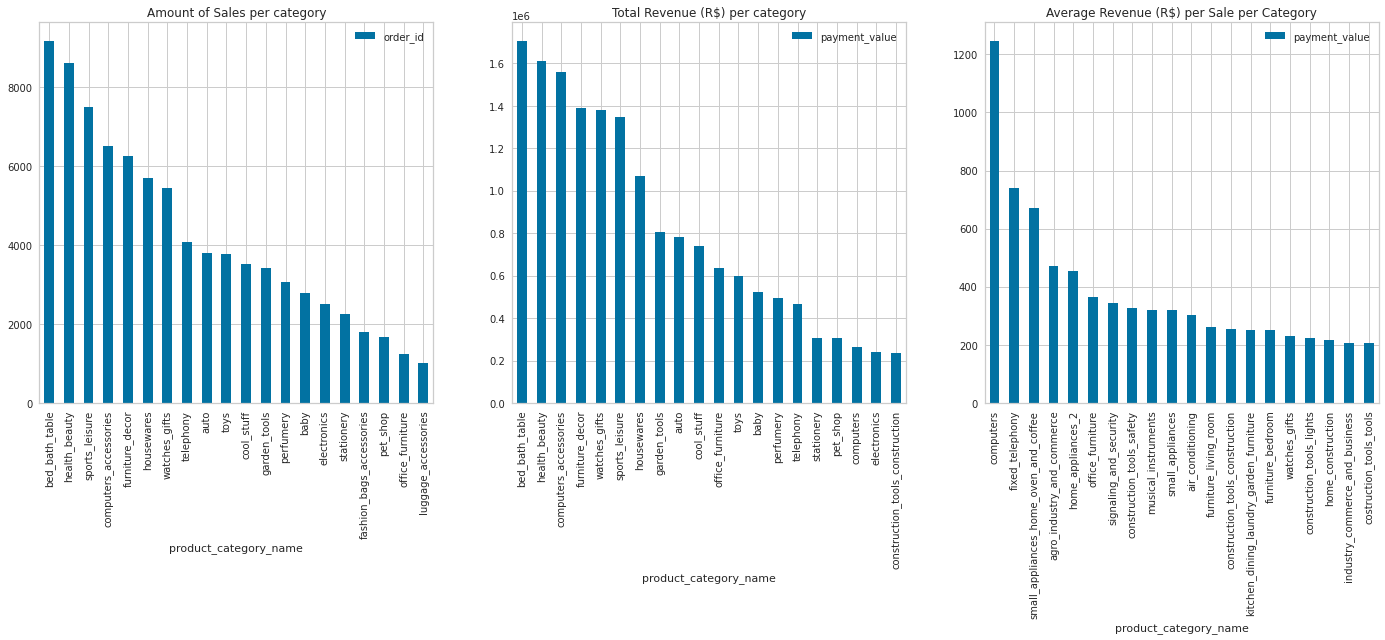

In [5]:
fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,3),(0,0))
olist.groupby("product_category_name").agg({"order_id": "nunique"})\
.sort_values('order_id', ascending=False).head(20).plot.\
bar(title='Amount of Sales per category', ax=axes)

axes = plt.subplot2grid((1,3),(0,1))
olist.groupby("product_category_name").agg({"payment_value": "sum"})\
.sort_values('payment_value', ascending=False).head(20).plot.\
bar(title='Total Revenue (R$) per category',ax=axes)

axes = plt.subplot2grid((1,3),(0,2))
olist.groupby("product_category_name").agg({"payment_value": "mean"})\
.sort_values('payment_value', ascending=False).head(20).plot.\
bar(title='Average Revenue (R$) per Sale per Category',ax=axes)

Most of the products sold were in bed_bath_table category, meaning products like sheets, blankets, silverware. This category is also the leader for the total revenue. We can see that health_beauty is also very important. The Average Revenue per Sale is leaded by computers. 

There is too many categories in the dataset for someone to make sense of. Since encoding (one hot encoding) is necessary to run the algorithms, I only considered the top 10 categories in order to reduce the amount of columns that will be created in the dataset.   

<AxesSubplot:title={'center':'Top 50 sellers - Amount of Sales'}, xlabel='seller_id'>

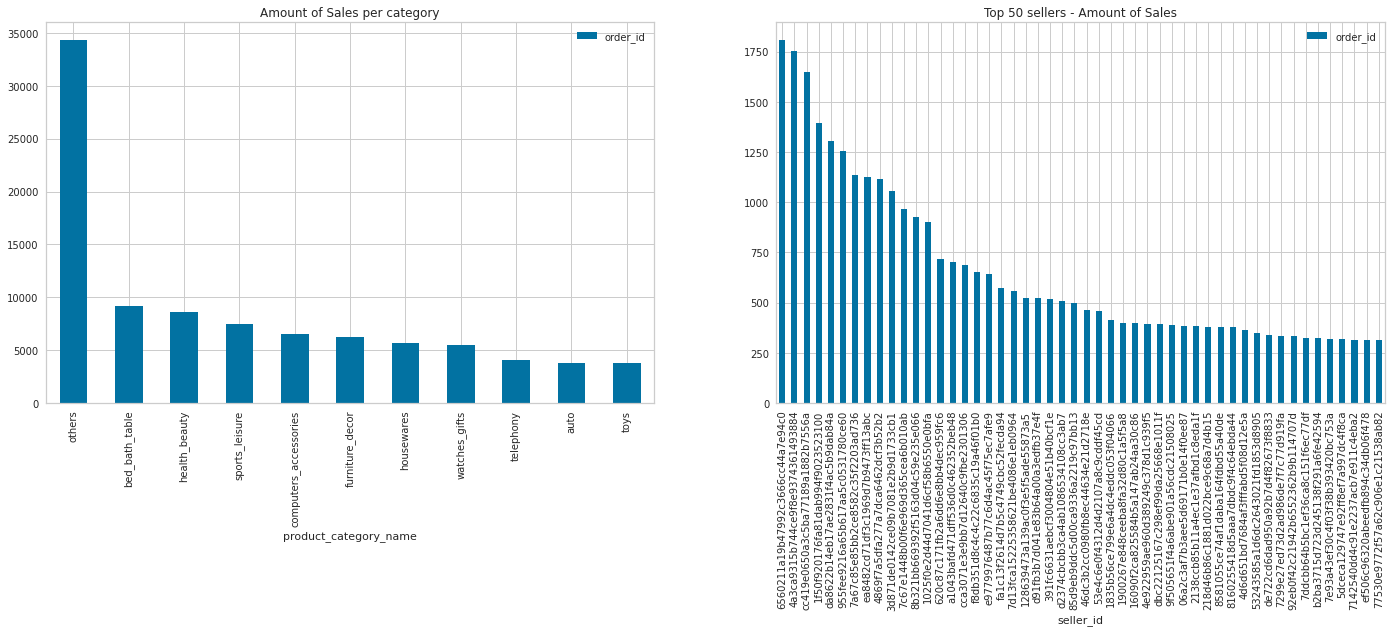

In [6]:
prod_cat_name = olist.groupby("product_category_name")\
.agg({"order_id": "nunique"}).sort_values('order_id', ascending=False).index.\
to_list()
outras_cat = list((Counter(prod_cat_name)-Counter(prod_cat_name[0:10])).elements())
olist = olist.replace(outras_cat,'others')

fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,2),(0,0))
olist.groupby("product_category_name").agg({"order_id": "nunique"})\
.sort_values('order_id', ascending=False).plot.\
bar(title='Amount of Sales per category',ax=axes)

prod_cat_name = prod_cat_name[0:10]
prod_cat_name.append('others')
prod_cat_name.sort()

axes = plt.subplot2grid((1,2),(0,1))
olist.groupby("seller_id").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False).head(50).plot.bar(
    title='Top 50 sellers - Amount of Sales',ax=axes)

We can see above that we have some real good sellers. One of them almost reached 2k sales! 

In [7]:
aux_seller = olist.groupby("seller_id").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False)
N_totalsellers,aux = olist.groupby("seller_id").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False).shape
N_uniquesell,aux = aux_seller[aux_seller.order_id==1].shape
print(f'There is {round(((N_uniquesell)/N_totalsellers)*100,2)}% sellers with only one sale.')

There is 18.51% sellers with only one sale.


However, there are a lot of one sale sellers too.

In [8]:
olist['order_delivered_customer_date'] = pd.\
to_datetime(olist.order_delivered_customer_date)
olist['order_estimated_delivery_date'] = pd.\
to_datetime(olist.order_estimated_delivery_date)
olist['review_creation_date'] = pd.to_datetime(olist.review_creation_date)
olist['review_answer_timestamp'] = pd.to_datetime(olist.review_answer_timestamp)

olist['delivery_delay'] = olist.order_delivered_customer_date-\
olist.order_estimated_delivery_date
olist['delivery_delay'] = olist.delivery_delay.astype('timedelta64[D]')
olist['delay_review_response'] = olist.review_answer_timestamp-\
olist.review_creation_date
olist['delay_review_response'] = olist.delay_review_response.\
astype('timedelta64[D]')

olist = olist.drop(columns=['order_delivered_customer_date',
                            'order_estimated_delivery_date',
                            'review_creation_date', 'review_answer_timestamp'])


In the code above I just created the 'delivery delay' column to replace the info of delivery estimation and actual deliverance. This way I have only one column instead of two in the dataset.

<AxesSubplot:xlabel='seller_state'>

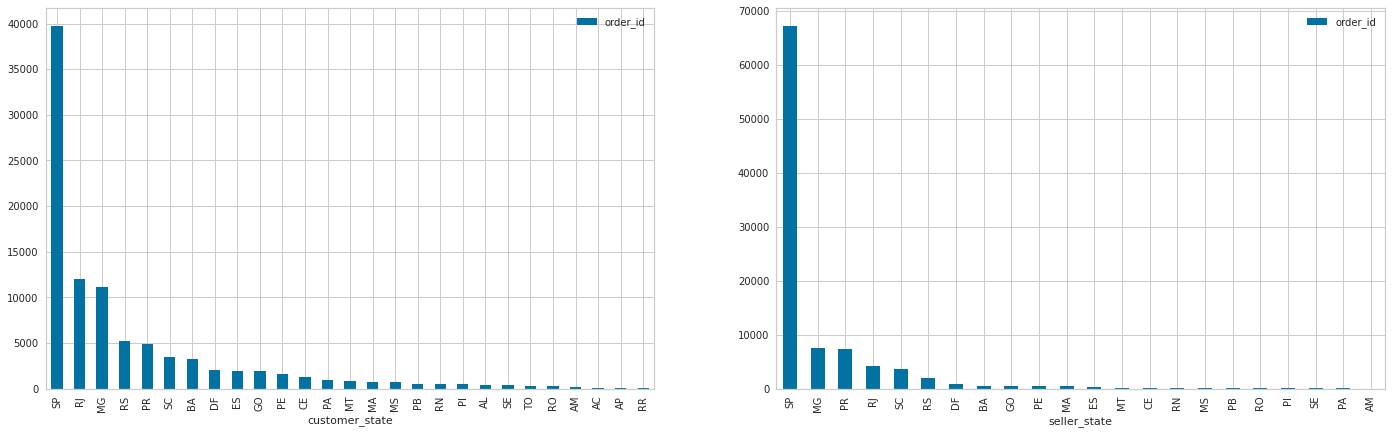

In [9]:
fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,2),(0,0))
olist.groupby('customer_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(ax=axes)
axes = plt.subplot2grid((1,2),(0,1))
olist.groupby('seller_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(ax=axes)

The boxplots above are the geographic distribution of customers and sellers, per Brazilian state. There are 27 states in Brazil, but we can see that transactions are dominated by southeast states, followed by south states. Other regions like north, northeast and central-west are barely present. So I aggregated this information in 3 categories: Southeast, South and Others.

<AxesSubplot:title={'center':'Sellers by region'}, xlabel='seller_state'>

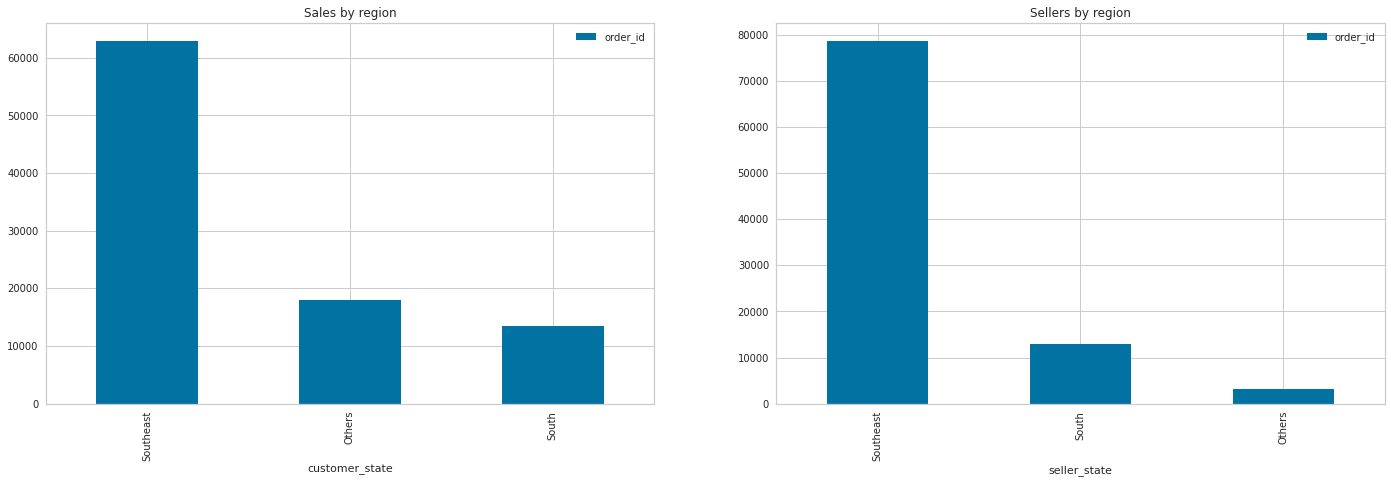

In [10]:
States = olist.groupby('customer_state').agg({'order_id':'nunique'})

Southeast = ['SP','RJ','MG']
South = ['RS','SC','PR']
Others = list((Counter(States.index)-Counter(Southeast)-Counter(South)).elements())

olist = olist.replace(Southeast,'Southeast')
olist = olist.replace(South,'South')
olist = olist.replace(Others,'Others')

fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,2),(0,0))
olist.groupby('customer_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(title = 'Sales by region',
                                          ax=axes)
axes = plt.subplot2grid((1,2),(0,1))
olist.groupby('seller_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(title = 'Sellers by region',
                                          ax=axes)



The southeast dominance is still present, but like these I will have less columns when applying the one hot encoding.

Below I applied the one hot encoding. It transforms categoric variables into columns that has only zeros and ones, so something numerical. It means, something that Kmeans and Hierarchical Clustering can deal with. So, for every possible register that a categorical variable might have, a column will be created. "One" is assigned for the specific column that matches the register and 0 for the others.    

In [11]:
enc = OneHotEncoder(sparse = False)


olist[['Cust_Others','Cust_South','Cust_Southeast']] = enc.fit_transform(
    olist[['customer_state']])
olist[['Sel_Others','Sel_South','Sel_Southeast']] = enc.fit_transform(
    olist[['seller_state']])
olist[prod_cat_name] = enc.fit_transform(olist[['product_category_name']])

olist_encoded = olist.drop(['customer_state','seller_state',
                            'product_category_name'],axis=1)

In [12]:
olist_encoded.tail(10)

,order_id,order_item_id,product_id,seller_id,price,freight_value,payment_value,review_score,product_name_length,product_description_length,...,bed_bath_table,computers_accessories,furniture_decor,health_beauty,housewares,others,sports_leisure,telephony,toys,watches_gifts
119128,8c1d27c10cc60cc369a428813bb71350,1.0,9680a78df870a1cb6ae00cb3436fe06a,a72f15980dc3e9bfd1a49ac9b2f3af65,89.90,18.73,108.63,4.0,50.0,1141.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119129,39e89b39b5cc8b5e3a38f23e915d1823,1.0,24fcd474105d95d2002f38f0cacf87ee,72c73be2b085b9d57650dd53eb2004c9,29.40,17.92,47.32,5.0,48.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119131,fbff77db5421bb7e1da292db45d07e75,1.0,654ccc4e5459e7ba6b8d9fb04c45b9db,2d8cfba3fcd3170555941605edaa196a,45.00,10.96,8.25,5.0,45.0,1403.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
119132,fbff77db5421bb7e1da292db45d07e75,1.0,654ccc4e5459e7ba6b8d9fb04c45b9db,2d8cfba3fcd3170555941605edaa196a,45.00,10.96,47.71,5.0,45.0,1403.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
119134,5bacbd9f42bd029c3a296501224e193e,1.0,710e8b076db06c8e5343a9e23f0e3d83,8dd386be0767c330276ea6a3f96532d3,44.99,22.25,134.48,5.0,60.0,645.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
119135,5bacbd9f42bd029c3a296501224e193e,2.0,710e8b076db06c8e5343a9e23f0e3d83,8dd386be0767c330276ea6a3f96532d3,44.99,22.25,134.48,5.0,60.0,645.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
119138,1ab38815794efa43d269d62b98dae815,1.0,31ec3a565e06de4bdf9d2a511b822b4d,babcc0ab201e4c60188427cae51a5b8b,79.00,14.13,93.13,5.0,40.0,516.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
119140,735dce2d574afe8eb87e80a3d6229c48,1.0,1d187e8e7a30417fda31e85679d96f0f,d263fa444c1504a75cbca5cc465f592a,399.00,45.07,444.07,5.0,43.0,729.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119141,25d2bfa43663a23586afd12f15b542e7,1.0,6e1c2008dea1929b9b6c27fa01381e90,edf3fabebcc20f7463cc9c53da932ea8,219.90,24.12,244.02,4.0,19.0,531.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119142,1565f22aa9452ff278638e87cc895678,1.0,9c1e194db1d35a79d962ea610bfe0868,f3862c2188522d89860c38a3ea8b550d,15.50,12.79,28.29,5.0,40.0,871.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


So far, I basically merged information of orders. Now, I need to aggregate this data for sellers. I do this using the groupby below. For some variables the aggregation was done in terms of mean value, others maximum value, others sum. I tried to use what made the most sense to me, but there are countless other ways to do it.  

In [13]:
data = olist_encoded.groupby('seller_id').agg({'order_id':'nunique',
                                        'product_id':'nunique',
                                        'payment_value':'mean',
                                        'review_score':'mean',
                                        'product_name_length':'mean',
                                        'product_description_length':'mean',
                                        'product_photos_qty':'mean',
                                        'delivery_delay':'mean',
                                        'delay_review_response':'mean',
                                        'Cust_Others':'sum',
                                        'Cust_Southeast':'sum',
                                        'Cust_South':'sum',
                                        'Sel_Others':'max',
                                        'Sel_Southeast':'max',
                                        'Sel_South':'max',
                                        'auto':'sum',
                                        'bed_bath_table':'sum',
                                        'computers_accessories':'sum',
                                        'furniture_decor':'sum',
                                        'health_beauty':'sum',
                                        'housewares':'sum',
                                        'others':'sum',
                                        'sports_leisure':'sum',
                                        'telephony':'sum',
                                        'toys':'sum',
                                        'watches_gifts':'sum',
                                              })
data

,order_id,product_id,payment_value,review_score,product_name_length,product_description_length,product_photos_qty,delivery_delay,delay_review_response,Cust_Others,...,bed_bath_table,computers_accessories,furniture_decor,health_beauty,housewares,others,sports_leisure,telephony,toys,watches_gifts
seller_id,,,,,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3,1,916.020000,3.666667,40.000000,849.000000,2.000000,-16.333333,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
001cca7ae9ae17fb1caed9dfb1094831,192,11,202.367811,3.974249,35.828326,471.974249,1.789700,-13.566524,2.150215,47.0,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0,0.0
002100f778ceb8431b7a1020ff7ab48f,50,24,42.160862,4.086207,55.189655,654.689655,1.000000,-8.517241,1.655172,9.0,...,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004c9cd9d87a3c30c522c48c4fc07416,143,78,154.792303,4.175758,56.236364,530.296970,1.054545,-11.909091,2.327273,30.0,...,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00720abe85ba0859807595bbf045a33b,13,9,119.938462,3.653846,43.576923,493.192308,2.230769,-12.730769,0.884615,4.0,...,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc470761de7d0232558ba5e786e57b7,27,15,74.454063,4.281250,54.968750,835.937500,1.531250,-11.781250,1.593750,8.0,...,0.0,0.0,1.0,0.0,10.0,13.0,1.0,0.0,0.0,6.0
ffdd9f82b9a447f6f8d4b91554cc7dd3,18,12,171.786667,4.285714,49.428571,517.095238,1.190476,-12.238095,2.380952,0.0,...,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
ffeee66ac5d5a62fe688b9d26f83f534,14,3,161.396429,4.214286,55.357143,801.285714,4.928571,-8.357143,1.785714,3.0,...,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0


Before running the clustering algorithms, I checked the correlation between variables. If two or more variables are too strongly correlated, they basically do not bring new information to define the clusters. Therefore, replicants can be droped to reduce the computational costs. 

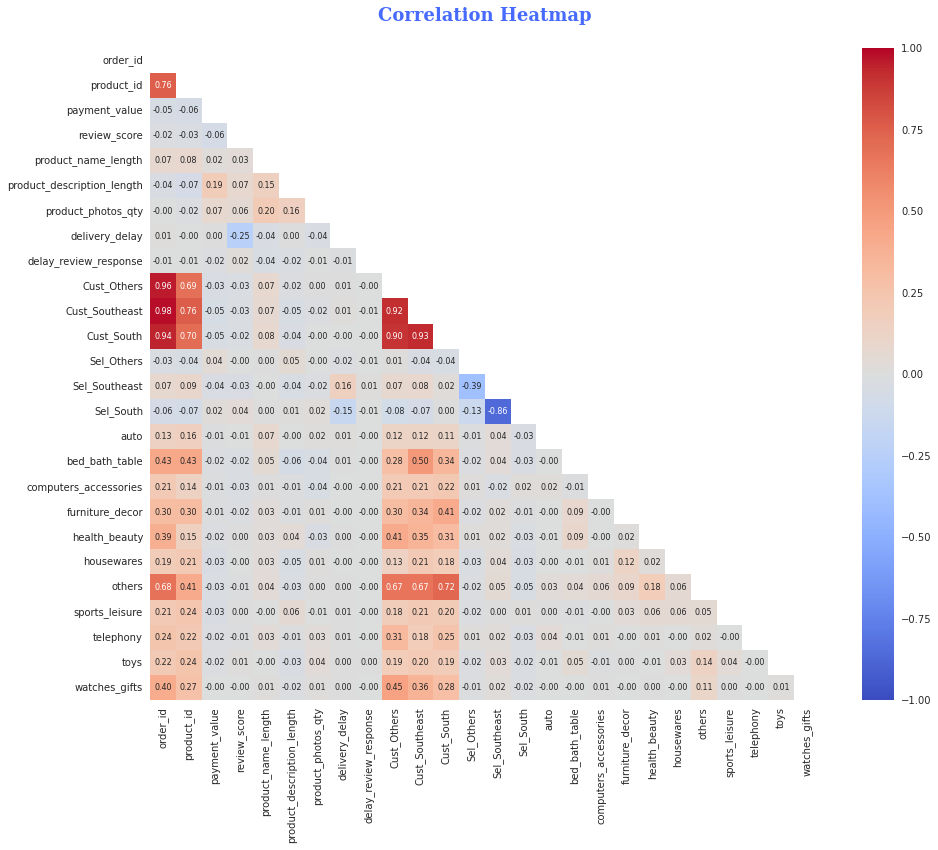

In [14]:
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,12))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, 
                 center=0, 
                 cmap="coolwarm")
plt.title(f"Correlation Heatmap\n", 
          fontdict=font_title)
plt.show()

There is a strong correlation between the amount of sales a seller did and the amount of product offered. I dropped the latter. 

Also, there is strong correlations between the variables of customer region and sellers region. I dropped the former.

In [15]:
data = data.drop(columns = ['product_id','Cust_Others','Cust_Southeast',
                            'Cust_South'])

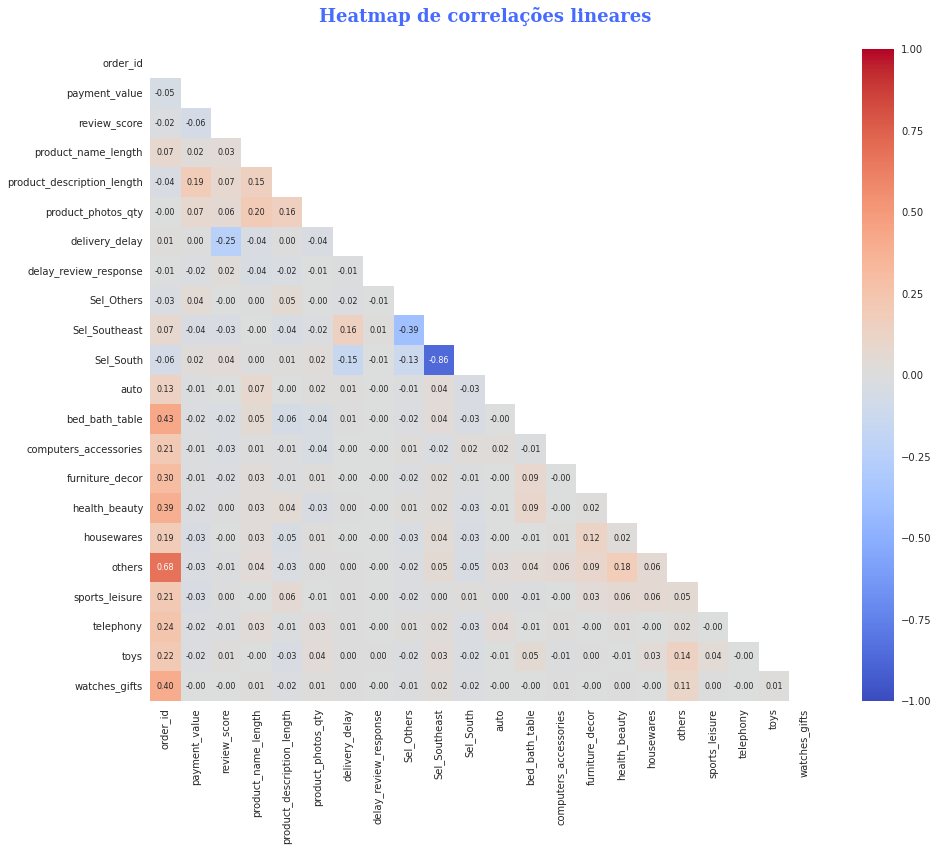

In [16]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,12))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, 
                 center=0, 
                 cmap="coolwarm")
plt.title(f"Heatmap de correlações lineares\n", 
          fontdict=font_title)
plt.show()

I'm happy with the correlation map now. Let's move on to implementing the clustering algorithms.

In [17]:
data

,order_id,payment_value,review_score,product_name_length,product_description_length,product_photos_qty,delivery_delay,delay_review_response,Sel_Others,Sel_Southeast,...,bed_bath_table,computers_accessories,furniture_decor,health_beauty,housewares,others,sports_leisure,telephony,toys,watches_gifts
seller_id,,,,,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3,916.020000,3.666667,40.000000,849.000000,2.000000,-16.333333,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
001cca7ae9ae17fb1caed9dfb1094831,192,202.367811,3.974249,35.828326,471.974249,1.789700,-13.566524,2.150215,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0,0.0
002100f778ceb8431b7a1020ff7ab48f,50,42.160862,4.086207,55.189655,654.689655,1.000000,-8.517241,1.655172,0.0,1.0,...,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004c9cd9d87a3c30c522c48c4fc07416,143,154.792303,4.175758,56.236364,530.296970,1.054545,-11.909091,2.327273,0.0,1.0,...,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00720abe85ba0859807595bbf045a33b,13,119.938462,3.653846,43.576923,493.192308,2.230769,-12.730769,0.884615,0.0,1.0,...,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc470761de7d0232558ba5e786e57b7,27,74.454063,4.281250,54.968750,835.937500,1.531250,-11.781250,1.593750,0.0,1.0,...,0.0,0.0,1.0,0.0,10.0,13.0,1.0,0.0,0.0,6.0
ffdd9f82b9a447f6f8d4b91554cc7dd3,18,171.786667,4.285714,49.428571,517.095238,1.190476,-12.238095,2.380952,0.0,0.0,...,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
ffeee66ac5d5a62fe688b9d26f83f534,14,161.396429,4.214286,55.357143,801.285714,4.928571,-8.357143,1.785714,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0


# K-means Clustering

I wrote a function for the Kmeans. It does the following things:


1.   It preprocesses the dataset using the MinMaxScaler.
2.   It plots the elbow curve for the distortion method automatically selecting the optimal number of clusters
3.   It plots the elbow curve for the Silhouette and Calinski_Harabasz method for validation
4.   It plots the silhouette coefficient for all the samples
5.   It plots the cluster distance
6.   It runs the Kmeans algorithm for the optimal number of clusters determined by the distortion method
7.   It returns the dataset with a new column with the label of the cluster

Notes:

The elbow curve with distortion method is a plot with the sum of squared distances, or distortion, in the y axis and the number of clusters in the x axis. This curve will always decrease, being that the distortion will be zero if the number of clusters is equal to the number of registers in the dataset (singletons - clusters with only one register). The interesting thing is that this plot always have an inflection point, where the distortion falls rapidly and the decrease slowly. That point is the optimal number of clusters.

The elbow curves using the Silhouette and Calinski_Harabasz are different from the distortion. In these types, we look for a maximum to determine the optimal number of clusters.





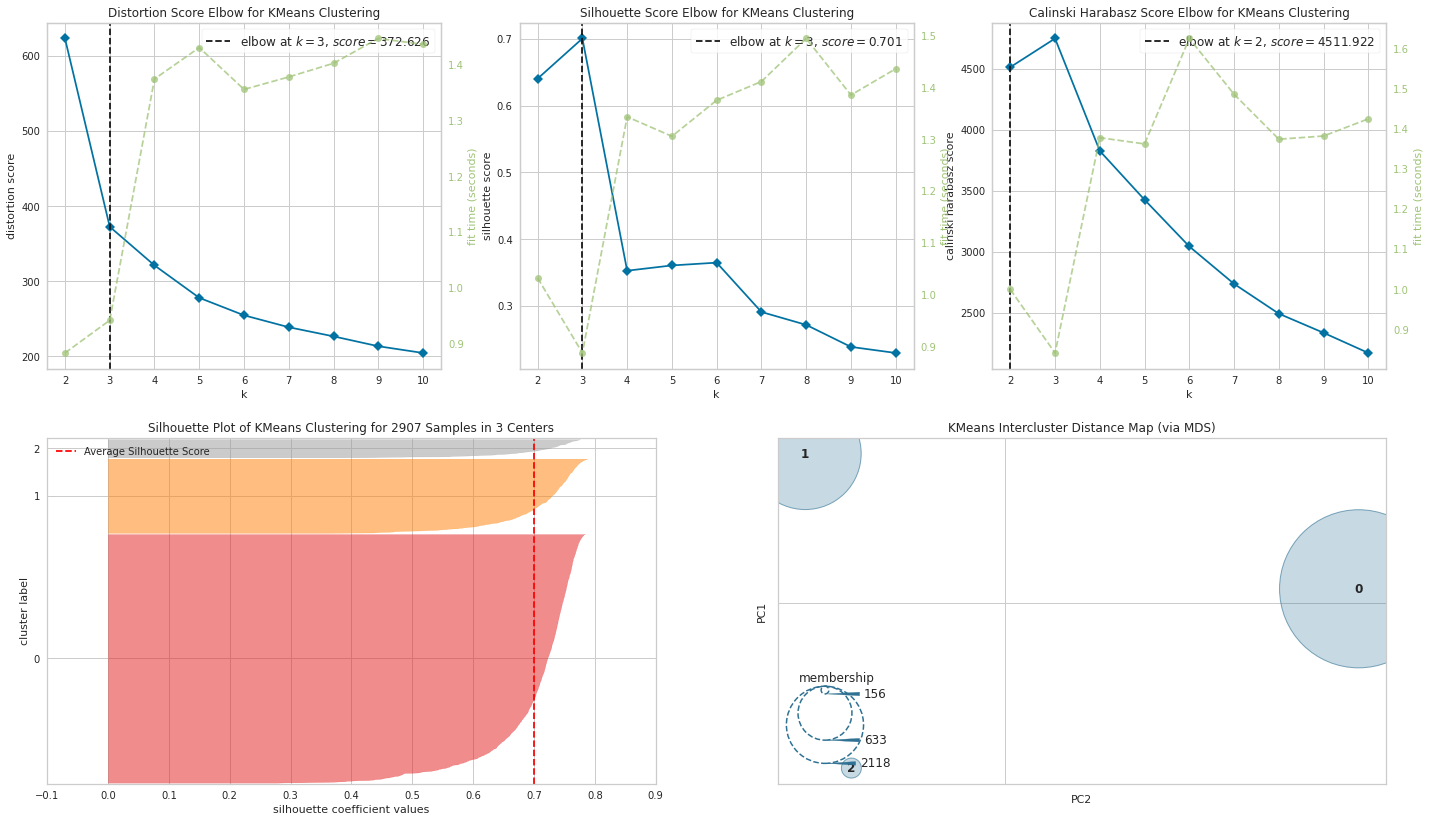

In [18]:
scaler = MinMaxScaler()

def Kmeansplots(data):
    X = data.copy()
    numerical_features = list(data.select_dtypes(include=['int64','float64',
                                                          'uint8']).columns)
    preprocessor = ColumnTransformer([
        ('scaler', scaler, numerical_features)])

    plt.figure(figsize=(24, 14));ax1 = plt.subplot(2,3,1);ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3);ax4 = plt.subplot(2,2,3);ax5 = plt.subplot(2,2,4)
    
    visual_grid1 = [
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(KMeans(),K=(4,12),metric='distortion',
                                      ax=ax1))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(KMeans(),K=(4,12),metric='silhouette',
                                      ax=ax2))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(KMeans(),K=(4,12),metric='calinski_harabasz',
                                      ax=ax3))]),'kelbowvisualizer')                    
                  ]

    i=0
    for viz in visual_grid1:
        viz[0].fit(X)
        if i==0:
          #Defining the best K by distortion method
          K = viz[0].named_steps['kelbowvisualizer'].elbow_value_ 
          i = i+1
        viz[0].named_steps[viz[1]].finalize()

    visual_grid2 = [(Pipeline([("preprocessor", preprocessor),("silhouettevisualizer",
                                      SilhouetteVisualizer(KMeans(K,random_state=0),ax=ax4))]),
                                      'silhouettevisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("distancevisualizer",
                                      InterclusterDistance(KMeans(K,random_state=0),ax=ax5))]),
                                        'distancevisualizer')]
    for viz in visual_grid2:
      viz[0].fit(X)
      viz[0].named_steps[viz[1]].finalize()

    # KMeans Pipeline with best K
    kmeans_model = Pipeline([("preprocessor", preprocessor),
                            ("kmeans", KMeans(K,random_state=0))])
    kmeans_model.fit(X)
    # Kmeans labels
    kmeans_labels = kmeans_model.named_steps['kmeans'].labels_  
    X["kmeans_label"] = kmeans_labels

    return X

X_0 = Kmeansplots(data)

The 3 elbow method defined the optimal number of clusters as 3. The Silhouette plots showed a high silhouette coefficient for all the registers, meaning that the clusters are dense. By the interdistance plot, it is evident that clusters are distant to one another.

In [19]:
X_0.groupby(['kmeans_label']).agg({'kmeans_label':'count',  
                                   'Sel_Others':'sum',
                                   'Sel_Southeast':'sum',
                                   'Sel_South':'sum'})

,kmeans_label,Sel_Others,Sel_Southeast,Sel_South
kmeans_label,,,,
0,2118,0.0,2118.0,0.0
1,633,0.0,0.0,633.0
2,156,156.0,0.0,0.0


The problem is that the cluster were basically defined by the sellers region, as seen in the result of the groupby above. So no useful information. Because of that, I removed the columns of the dataset and did the analisys once again.

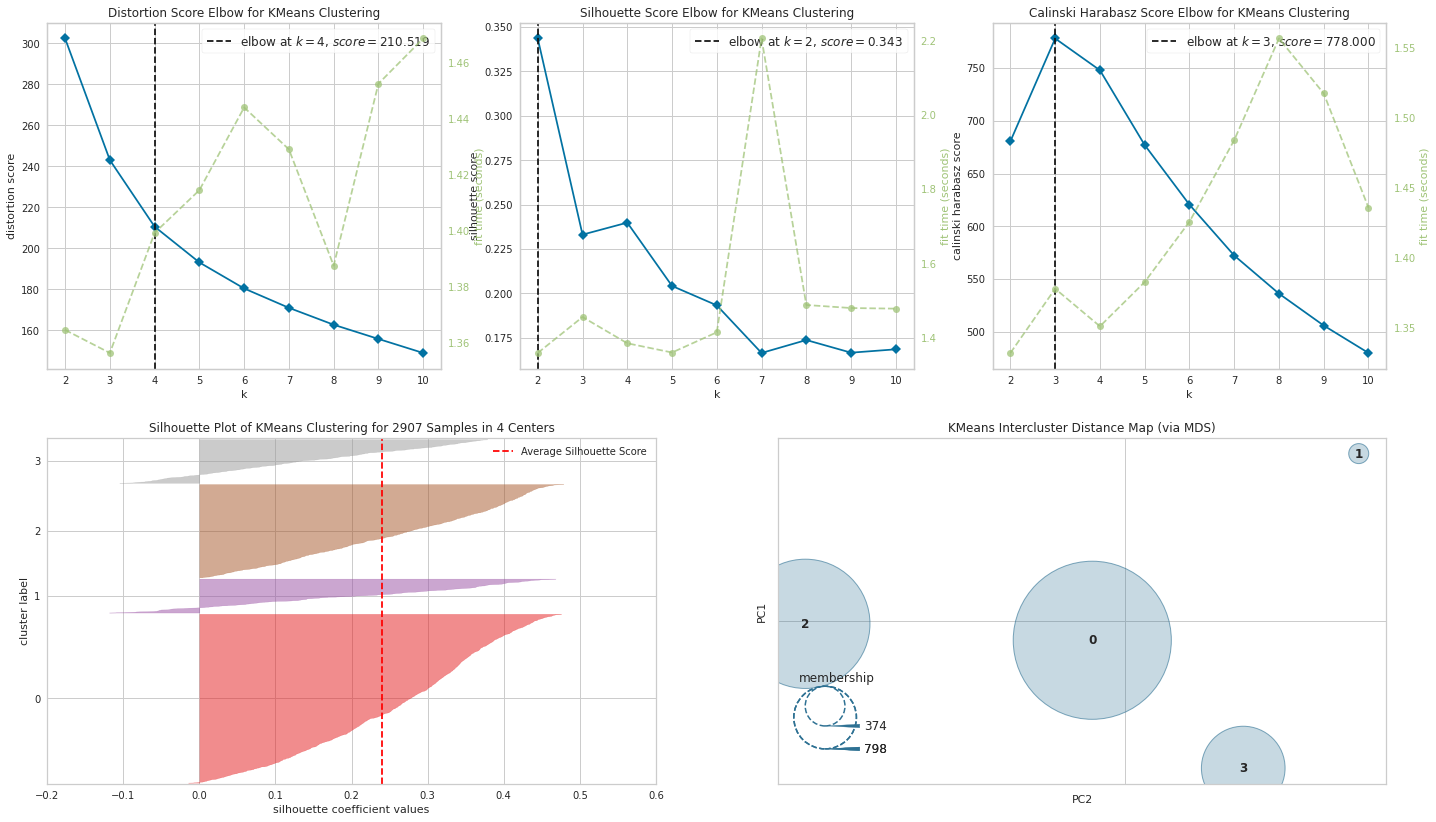

In [20]:
data_1 = data.drop(columns=['Sel_Others','Sel_South','Sel_Southeast'])
#data_1.to_csv(path+'seller_data_1.csv')
X_1= Kmeansplots(data_1)

The elbow curve with distortion method got 4 clusters. This is different for the elbow curve with the silhouette and Calinski Harabasz. But, for the Silhouette, even though the highest value is 2 clusters, 4 is a local maximum and for the Calinski Harabasz 4 is the second best option. So I decided to stick with 4 clusters.

The Silhouettte plot shows negative values for some registers in clusters 0, 1 and 2, what is not the best result. Also, the Average Silhouette Coeficient is low. It was a solid 0.7 when the sellers geopgraphical regions were considered but that was not useful.

The Intercluster Distance plot shows the custers are at a good distance of each other. 

In [21]:
X_1.groupby('kmeans_label').agg({'order_id':'count'})

,order_id
kmeans_label,
0,1444
1,291
2,798
3,374


The largest group is the cluster 3 followed by cluster 0. Below I checked the data in terms of the category of products.

<AxesSubplot:title={'center':'Median Number of Sales per Category per Cluster'}, xlabel='kmeans_label'>

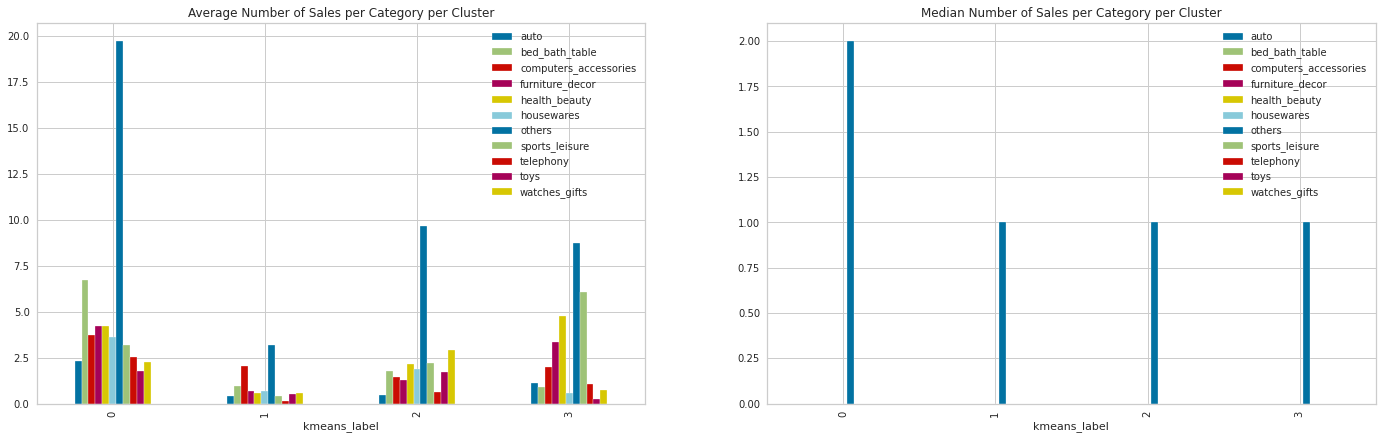

In [22]:
fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,2),(0,0))
X_1.groupby(['kmeans_label']).agg({'auto':'mean', 
                                   'bed_bath_table':'mean',
                                   'computers_accessories':'mean',
                                   'furniture_decor':'mean',
                                   'health_beauty':'mean',
                                   'housewares':'mean',
                                   'others':'mean',
                                   'sports_leisure':'mean',
                                   'telephony':'mean',
                                   'toys':'mean',
                                   'watches_gifts':'mean',
                                   }).plot.bar(ax = axes,
                                          title = 'Average Number of Sales per Category per Cluster')
axes = plt.subplot2grid((1,2),(0,1))                                   
X_1.groupby(['kmeans_label']).agg({'auto':'median', 
                                   'bed_bath_table':'median',
                                   'computers_accessories':'median',
                                   'furniture_decor':'median',
                                   'health_beauty':'median',
                                   'housewares':'median',
                                   'others':'median',
                                   'sports_leisure':'median',
                                   'telephony':'median',
                                   'toys':'median',
                                   'watches_gifts':'median',
                                   }).plot.bar(ax = axes,
                                          title = 'Median Number of Sales per Category per Cluster')
                                   

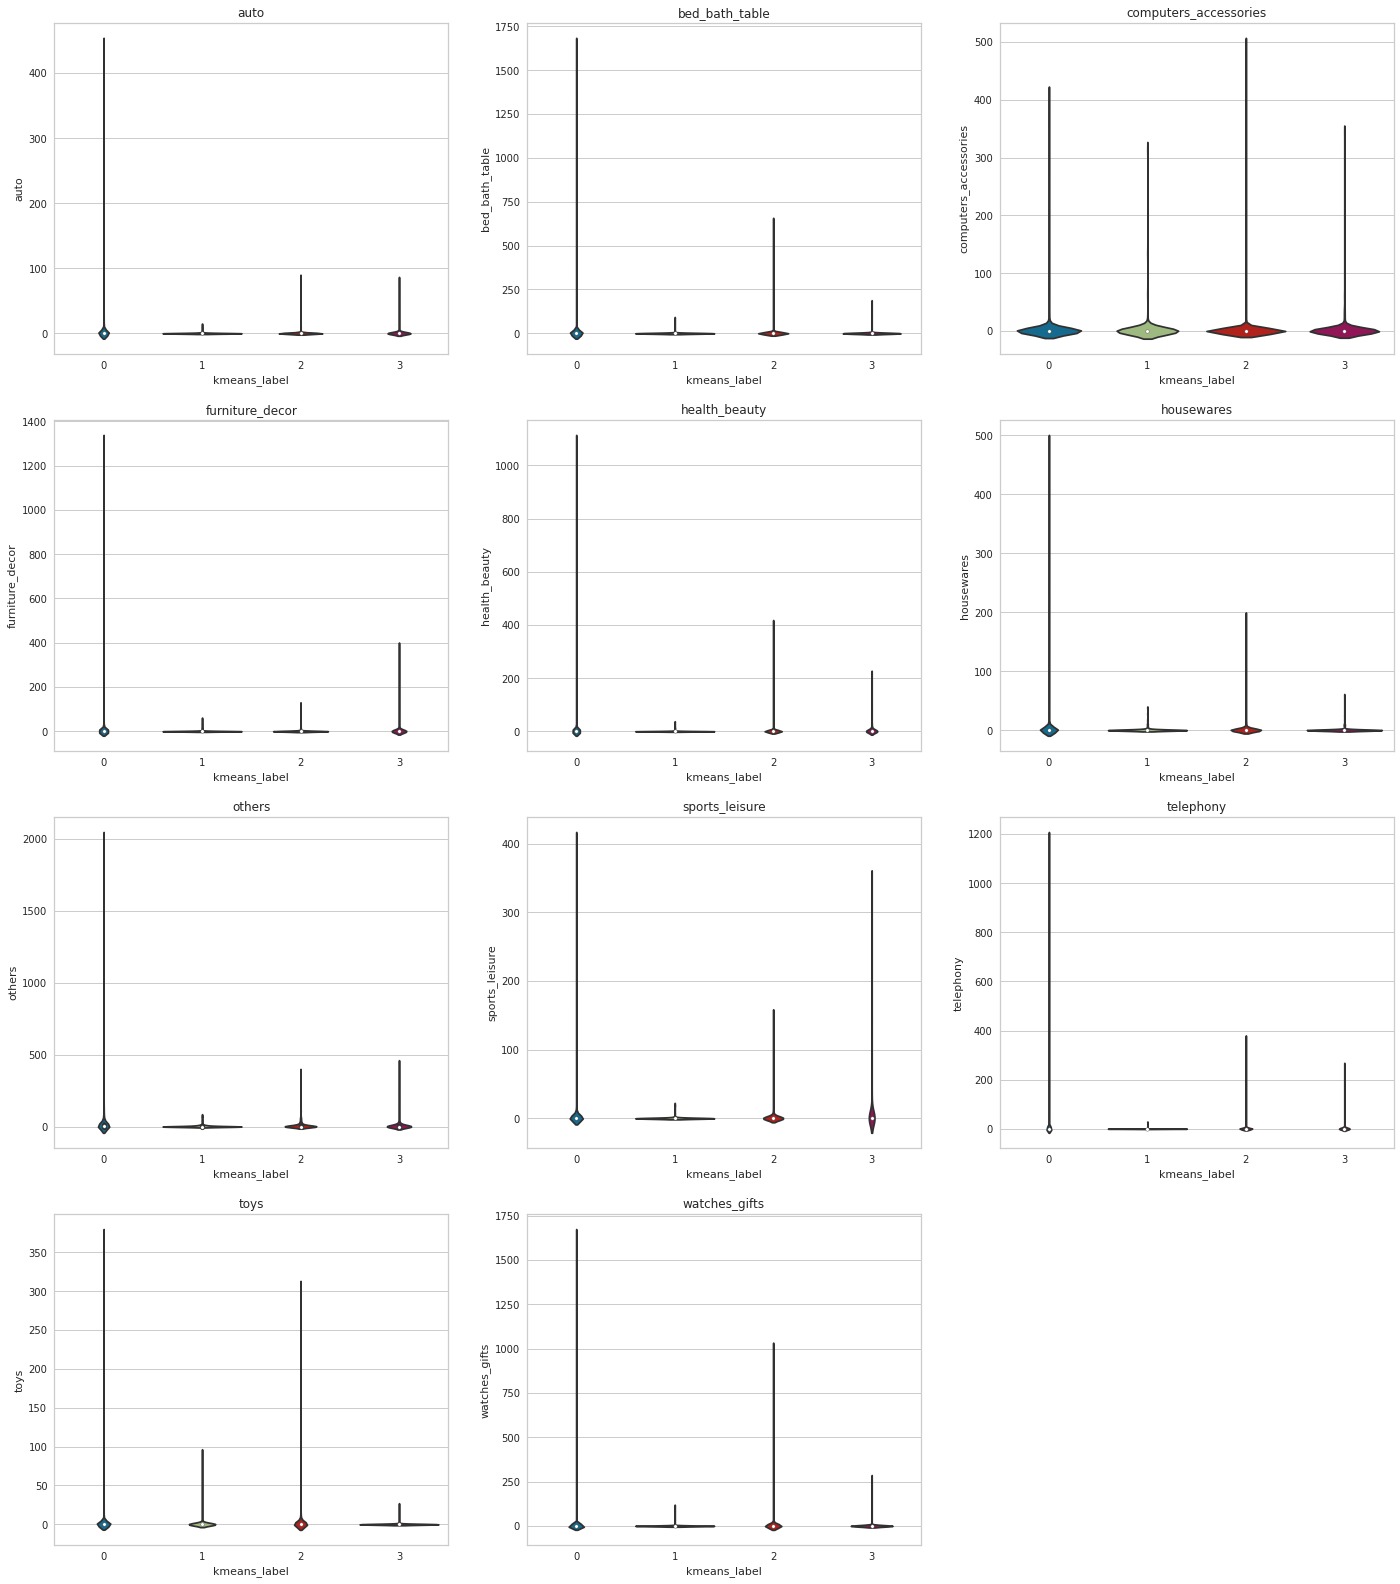

In [23]:
aux = X_1.columns
fig = plt.figure(figsize=(24,28))
a = 0; b=0
for i in aux[8:19]:
    axes = plt.subplot2grid((4,3),(a,b))
    sns.violinplot(x = X_1['kmeans_label'],y = X_1[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('kmeans_label')  
    b = b+1
    if b>=3:
      b = 0
      a = a+1

The bar plots above are the the mean and median number of sales per category per cluster. Apparently, there is no correspondace between the cluster and the category of the product. In the mean of sales, every category appears in every cluster and the median number of sales is zero for every category in every cluster except for the category "others". That means that at least 50% of the sellers in each cluster did not make a sell in those categories. This is all corroborated by the violin plots. All the violin are thick at the base and almost a straight line as it goes up, meaning that the large majority of points did not make a single sale at the category.

Therefore, I decided to drop these columns from the dataset looks appealing. So, I created the data_1_reduced dataset and ran the kmeans function once again.

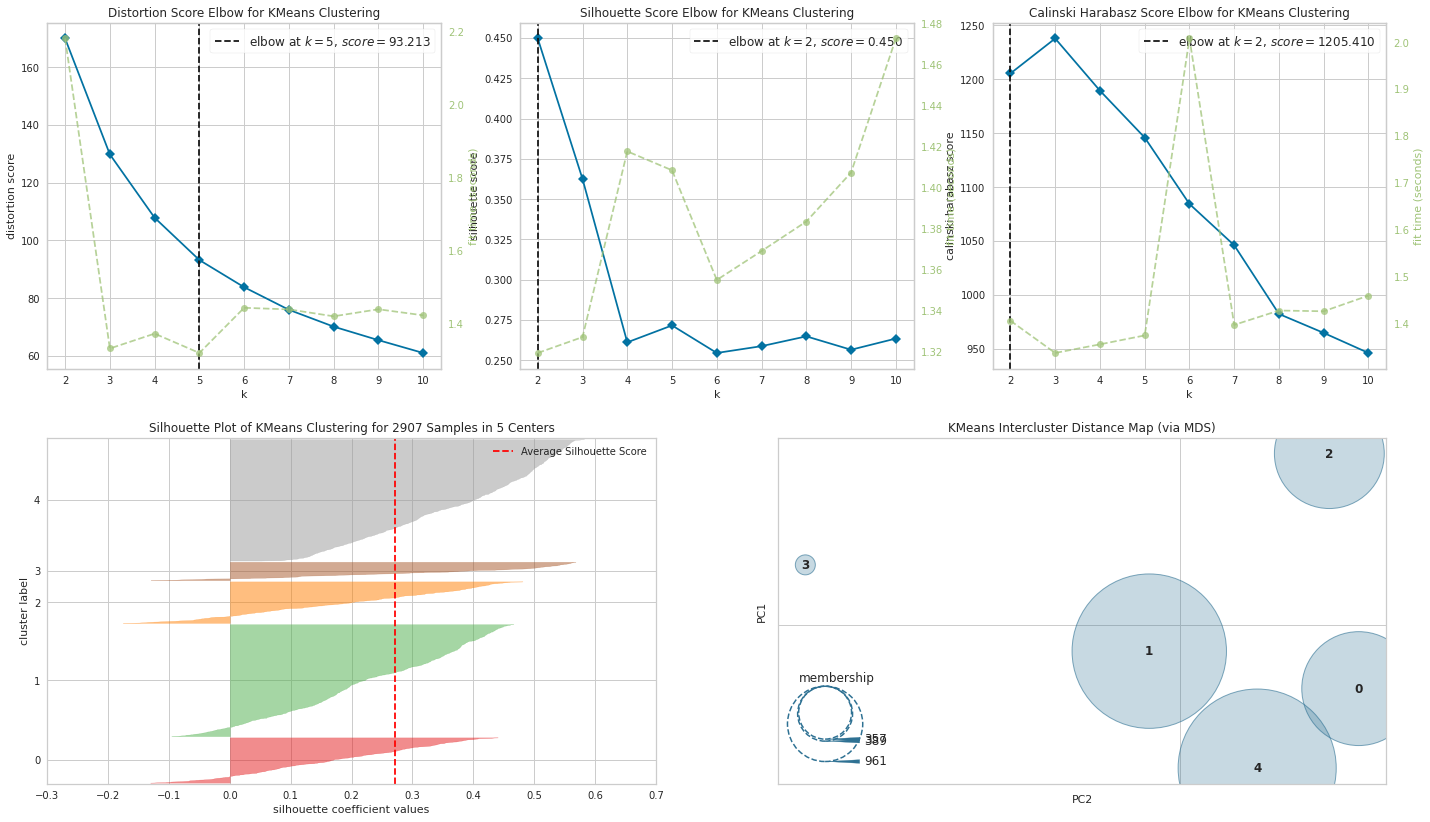

In [24]:
data_1_reduced = data_1[['order_id','payment_value','review_score',
                        'product_description_length','product_photos_qty',
                         'delivery_delay']]

X_1_reduced= Kmeansplots(data_1_reduced)

Now I got 5 clusters instead of the previous 3 and 4.

In [25]:
X_1_reduced.groupby('kmeans_label').agg({'order_id':['count','median'],
                                         'payment_value':'median',
                                         'review_score':'median',
                                         'product_description_length':'median',
                                         'product_photos_qty':'median',
                                         'delivery_delay':'median'                 
                                                          })

order_id        payment_value review_score  \
                count median        median       median   
kmeans_label                                              
0                 389    8.0    149.149320     4.447368   
1                 961   11.0    140.055000     3.875000   
2                 357    6.0    160.140923     4.466667   
3                 158    2.0    165.870000     1.816667   
4                1042    5.0    119.570985     4.666667   

             product_description_length product_photos_qty delivery_delay  
                                 median             median         median  
kmeans_label                                                               
0                            812.000000           4.400000     -12.666667  
1                            589.752475           1.666667     -11.660448  
2                           1925.000000           2.000000     -12.285714  
3                            609.910714           1.100962      -8.916667  
4                            617.321429           1.500000     -12.437690

The largest cluster is the number 2 followed by number 4.


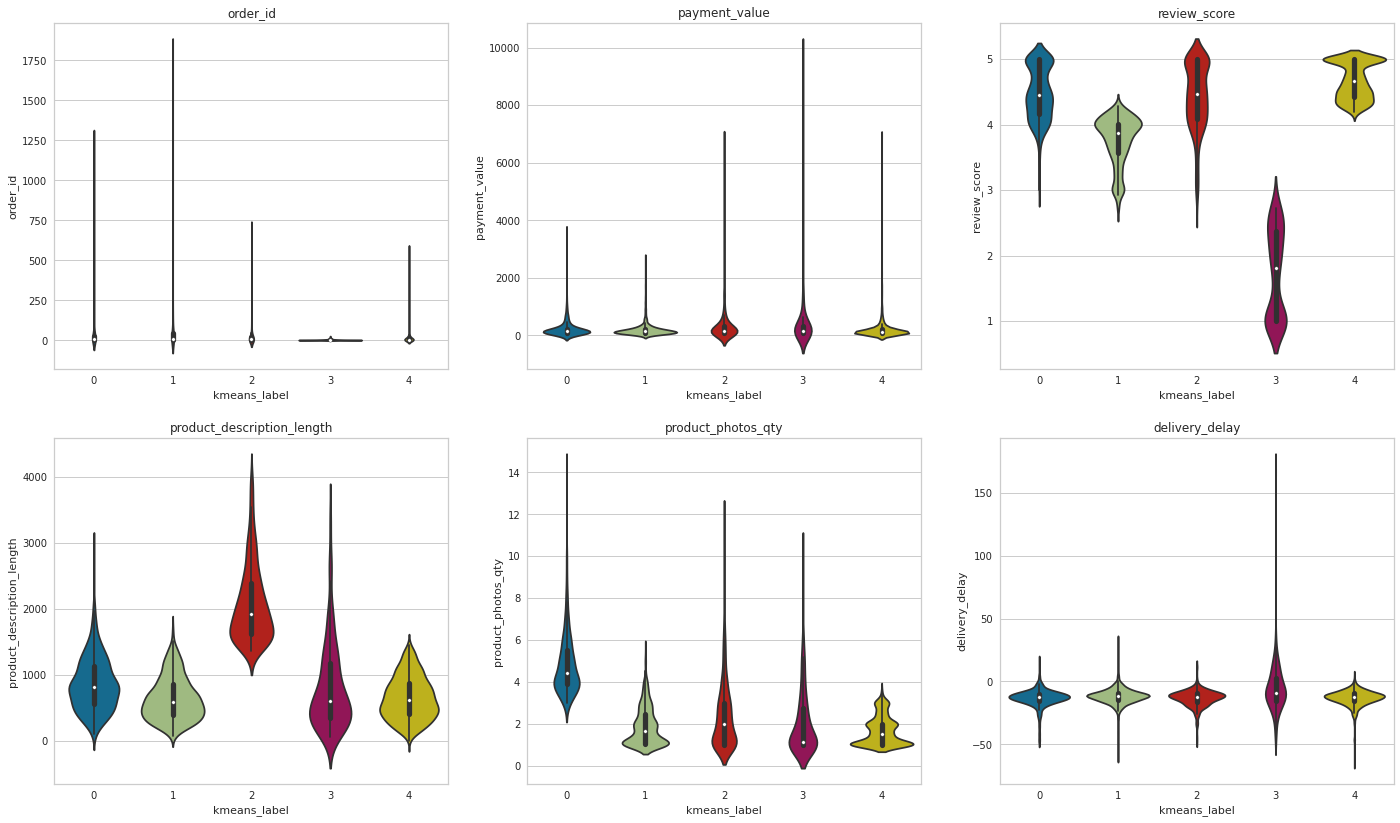

In [26]:
n_plot = 231
fig = plt.figure(figsize=(24,14))
for i in X_1_reduced.columns:
  if i!='kmeans_label':
    axes = fig.add_subplot(n_plot) 
    sns.violinplot(x = X_1_reduced['kmeans_label'],y = X_1_reduced[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('kmeans_label')
    n_plot = n_plot+1

### Cluster 0:
This group is very similar to cluster 3, but they put more pictures and small texts to describe their products.

### Cluster 1:
This is the cluster with the least members. Basically, what sets them apart is that they received lousy reviews from their customers and that is, in part, explained by the delivery delay. Most of these sellers did not manage to get their products delivered on time. They sold the least. Perhaps, it is possible to conclude that this cluster gathered the non-professionals online sellers. People that only needed to sell one item once and never had to do it again.

### Cluster 2:
It is the cluster with the most members. Most of them made a few sales and received the smallest payment value (with exceptions). They received the highest review score from their clients. It looks like they do not put too much effort in describing their products, because the have the lowest description length and the least pictures. Their products are delivered on time.

### Cluster 3:
Members of this cluster sold a bit more that those in cluster 0, they delivered on time and have good reviews. A clear characteristic is describing their products with a lot of text and not too many pictures. 

### Cluster 4:
This is the second largest group. The champions of sales are in this cluster, but you can find members that did not sell as much. They do not put much effort in describing their products, their products are delivered on time, but they did not received as good evaluations as those received by cluster 0.




# Hierarchical Clustering

First of all, I applied the dendogram to the data_1_reduced dataset. It takes longer than the Kmeans clustering to calculate, so I did not bother to try this for the data or data_1 since that would be even more time consuming.

As you can see, I did not applied any preprocessor.

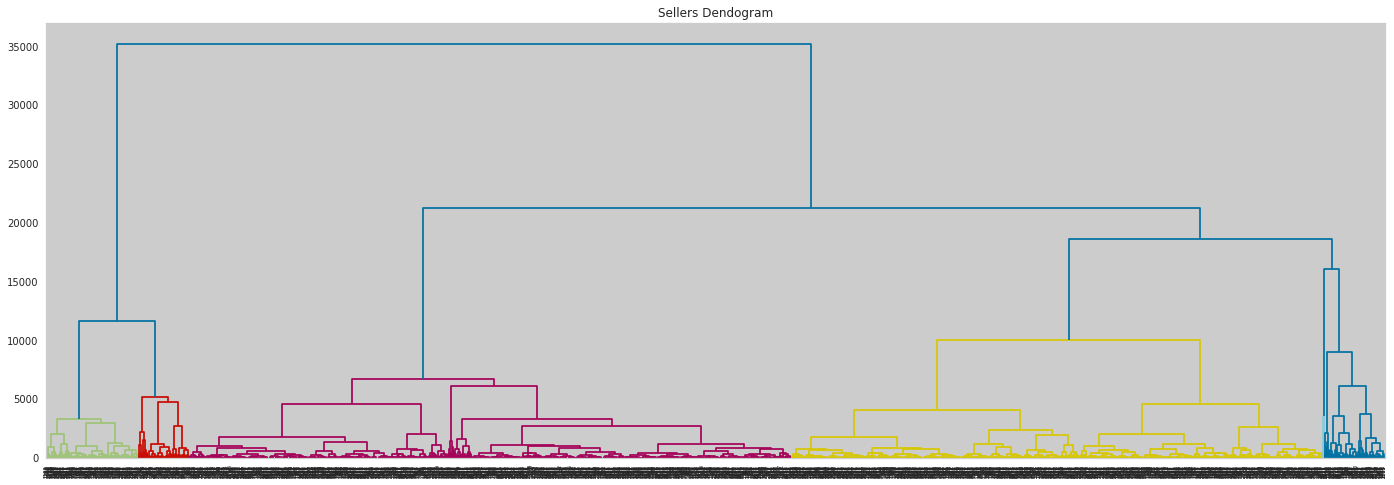

In [27]:
plt.figure(figsize=(24, 8))  
plt.title("Sellers Dendogram")
link = shc.linkage(data_1_reduced, method='ward',metric='euclidean')
dend = shc.dendrogram(link, color_threshold=11000)  

I set the threshould of 11000 on a hunch, by visually inspecting the dendogram. As a result, I got 6 clusters. Two of them are huge in members and one is ridiculously small.

In [28]:
X_hier = data_1_reduced.copy()
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
agrup = cluster.fit_predict(X_hier) 
X_hier['labels'] = agrup
X_hier.groupby('labels').agg({'order_id':['count','median'],
                                         'payment_value':'median',
                                         'review_score':'median',
                                         'product_description_length':'median',
                                         'product_photos_qty':'median',
                                         'delivery_delay':'median'                 
                                                          })

order_id        payment_value review_score product_description_length  \
          count median        median       median                     median   
labels                                                                         
0          1154    8.0    147.019981     4.297872                 926.500000   
1           131    5.0   1013.700000     4.250000                1099.228261   
2          1308    7.0    111.645000     4.235983                 425.410428   
3           108    4.0    193.150750     4.500000                2718.953846   
4             3    1.0   6929.310000     5.000000                1748.266667   
5           203    6.0    161.370000     4.352941                1841.551724   

       product_photos_qty delivery_delay  
                   median         median  
labels                                    
0                1.989130     -12.000000  
1                2.307692     -13.000000  
2                1.666667     -12.000000  
3                2.000000     -12.000000  
4                2.000000      -6.266667  
5                2.000000     -11.909091

So, I reached the conclusion that the cluster 4, the smallest group, is composed by outliers. What sets them apart is that they managed to sell online, on rare occasions, products with very high prices, much higher than the crowd of other products. 
The big groups, clusters 0 and 2, are similar but the former described the products with more detail, being the median of the description length twice as long as the latter. The median of photos is also higher.   

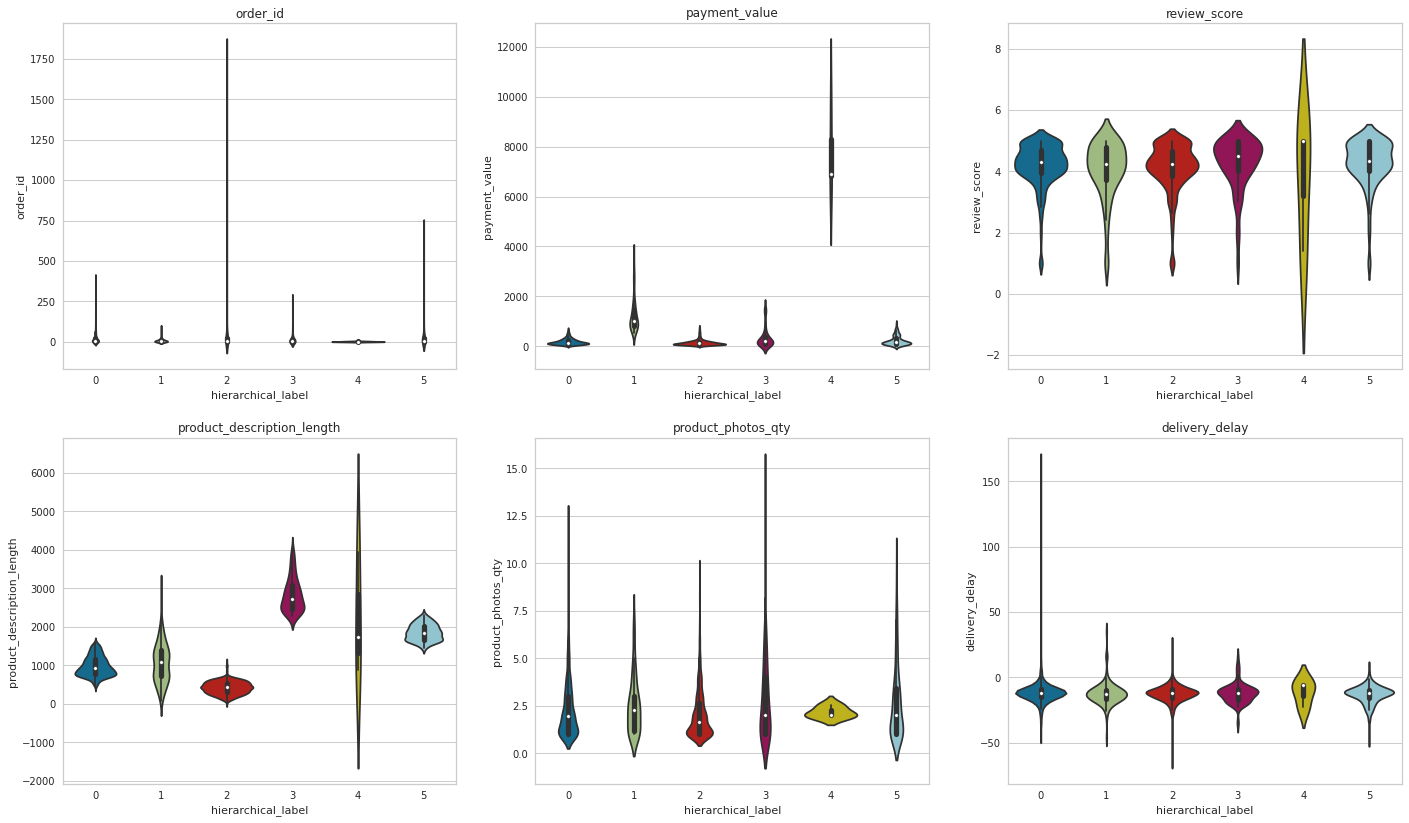

In [29]:
n_plot = 231
fig = plt.figure(figsize=(24,14))
for i in X_hier:
  if i!='labels':
    axes = fig.add_subplot(n_plot) 
    sns.violinplot(x = X_hier['labels'],y = X_hier[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('hierarchical_label')
    n_plot = n_plot+1

### Cluster 0:
It is the second largest cluster, the cluster 2 being the largest. They both sold low price products, received the same review from customers, and delivered without delay most of the time. Cluster 0 used more text to describe their products. They used more photos than the cluster 2 but the difference is more subtle.   

### Cluster 1:
Cluster 1 basically sold products with higher price than the rest. Of course, they were not nearly as expensive as those sold by cluster 4. The quantity of sales is not as expressive as other groups, but there are members that made more than 100 sales. They described their products with text similarly as cluster 0, perhaps even longer texts, ans posted a little bit more pictures.

### Cluster 2:
This is the largest group. They sold low price products, delivered mostly on time and received practically the same reviews as cluster 0. They described their products with much fewer text, half as long as cluster 0, and less pictures. In this group resides the sellers that sold the most quantity of products.  

### Cluster 3:
Cluster 3 contains sellers that sold low price products and some of them (very few) sold a good quantity of products. They used the longest text of all the clusters to describe their products.

### Cluster 4:
This is the smallest group, containing only 3 sellers. They are outliers in the dataset. What sets them apart is the extremely high price of their products. They sold tiny quantities. 


### Cluster 5:
This is a similar cluster to cluster 3: low price products; a few members sold a good quantity of products; nothing to notice about the review scores or the delivery delays. They did not use so much text as cluster 3, even though their descriptions are longer than cluster 0 and 2.




# Conclusions

Marketplaces are where buyers and sellers expect to find each other online in order to perform a transaction. Not only buyers are needed. Products need to be offered effectively. Therefore, it is important to know the sellers better to understand them. 

I performed a cluster analysis applied to a dataset of online sales. The aim of the analysis was the sellers and not the buyers. Two methods were applied: K-means and Hierarchical Clustering.

With the help Yellowbrick visualizers, K-means was very straightforward to use. Unfortunately, data from sellers location and product category did not help and had to be dropped. This technique found a group of sellers that received bad reviews and very limited number of sales (probably non professionals sellers).

The clusters from the hierarchical algorithm were separated based on a threshold set visually in the dendogram. It was less intuitive than K-means. I got a cluster of outliers that K-means did not get. This was interesting. The clusters were influenced by payment-value and description_length than others columns.

Another interesting to notice is that K-means and Hierarchical Clusters delivered very different results. For next cluster analysis, I will make sure I run both of them.